In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import src.basic_function_cap as bfc
import src.piano_key_notes as pkn
import ipywidgets as widgets
from ipywidgets import interact

# Hand region

In [110]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

def show_frame(frame_number, shift, threshold):
    _, mask = bfc.get_frame(cap, 814)
    _, frame = bfc.get_frame(cap, frame_number)
    mask = bfc.crop_frame(mask, 375, 0, 540-375, mask.shape[1], show=False)
    frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
    plt.figure(figsize=(16,16))
    plt.imshow(frame)
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(frame - mask + shift)
    plt.show()

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=814, step=1, value=10),
        shift=widgets.IntSlider(min=0, max=30, step=1, value=10),
        threshold=widgets.IntSlider(min=0, max=100, step=1, value=30))

interactive(children=(IntSlider(value=10, description='frame_number', max=814), IntSlider(value=10, descriptio…

<function __main__.show_frame(frame_number, shift, threshold)>

In [90]:
def get_hand_region(frame, threshold=30, show=False):
    new_frame = frame.std(axis=2)
    new_frame[:30,:] = 0
    new_frame[new_frame < threshold] = 0
    new_frame[new_frame >= threshold] = 255
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(new_frame, cmap='gray')
        plt.show()
    return new_frame

def get_hand_region_x(frame, threshold=30, show=False):
    new_frame = get_hand_region(frame, threshold)
    x_mean = np.mean(new_frame, axis=0)
    x_mean = np.convolve(x_mean, np.ones(20), mode='same')
    new_frame[:,x_mean > 5] = 255
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(new_frame, cmap='gray')
        plt.show()
    return new_frame

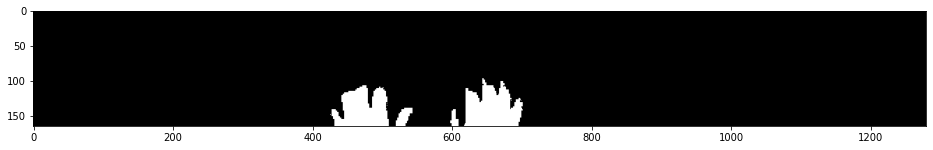

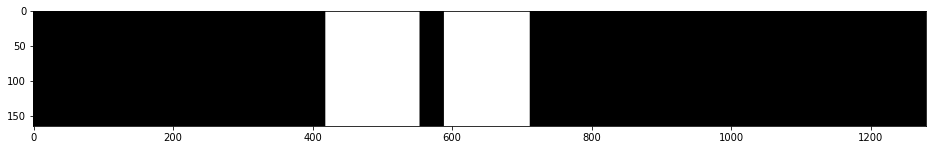

In [91]:
_, frame = bfc.get_frame(cap, 10)
frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
frame_hands_isolated = get_hand_region(frame, 30, True)
_ = get_hand_region_x(frame, 30, True)

# Show notes

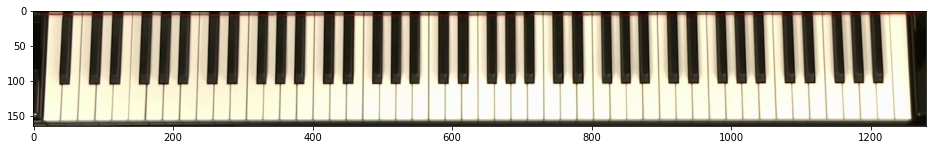

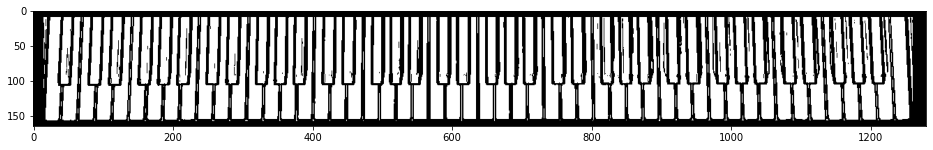

Number of connected components: 88


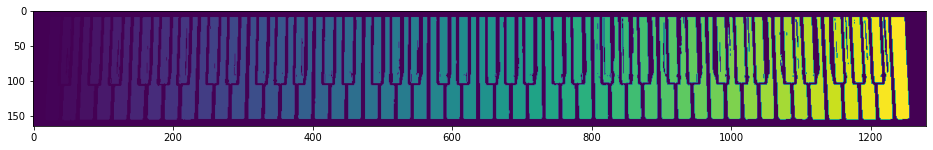

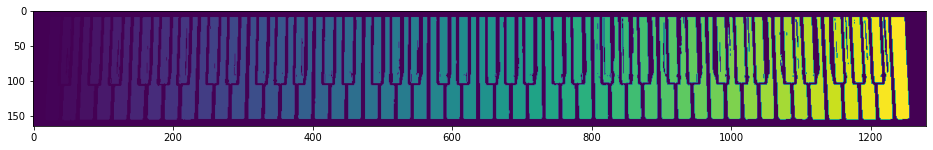

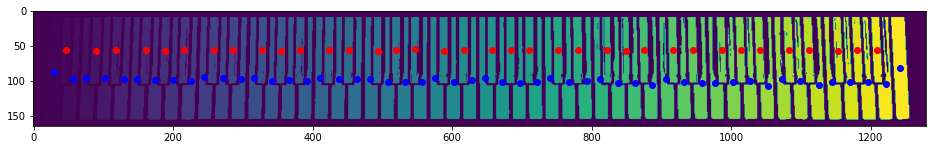

  0%|          | 0/36 [00:00<?, ?it/s]

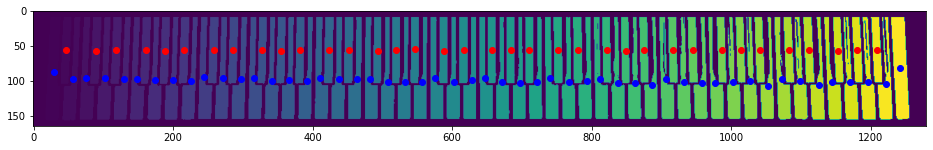

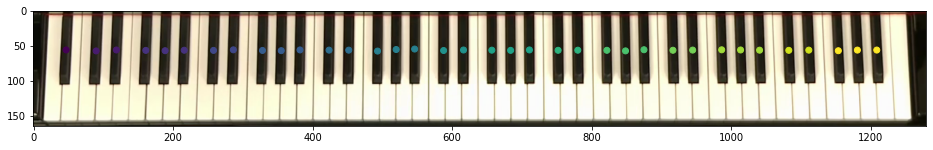

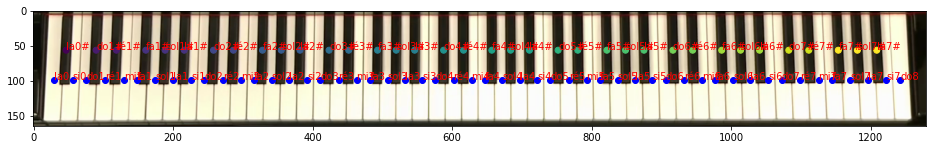

In [92]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
image = bfc.get_frame(cap, 814)[1]
image = bfc.crop_frame(image, 375, 0, 540-375, image.shape[1], show=True)
pipe = pkn.pipeline(image, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=True)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

In [93]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]
def show_frame(frame_number, key):
    _, image = bfc.get_frame(cap, frame_number)
    image = bfc.crop_frame(image, 375, 0, 540-375, image.shape[1], show=False)
    _ = pkn.highlight_keys(image=image, labels=labels, keys = key, color = [g,g,r], show=True)

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=814, step=1, value=10),
        key=widgets.IntSlider(min=0, max=88, step=1, value=10))

interactive(children=(IntSlider(value=10, description='frame_number', max=814), IntSlider(value=10, descriptio…

<function __main__.show_frame(frame_number, key)>

# Check difference above hands

In [94]:
_, frame = bfc.get_frame(cap, 10)
frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
frame_hands_isolated = get_hand_region(frame, 30, False)
frame_hands_isolated_x = get_hand_region_x(frame, 30, False)

In [95]:
def get_difference_mask(cap, frame_number, shift=10, show=False):
    _, mask = bfc.get_frame(cap, 814)
    _, frame = bfc.get_frame(cap, frame_number)
    mask = bfc.crop_frame(mask, 375, 0, 540-375, mask.shape[1], show=False)
    frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
    diff = frame - mask + shift
    if show:
        plt.figure(figsize=(16,16))
        plt.imshow(diff)
        plt.show()
    return diff

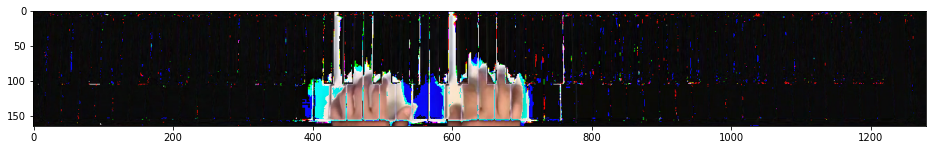

In [96]:
diff = get_difference_mask(cap, 10, show=True)

[12.66785714 10.4        13.3625    ]


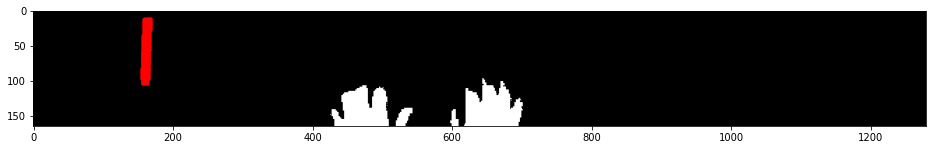

In [142]:
# We check if the key k is pressed by checking all pixels in the key k that are not in the hands

def get_list_pixels(image_hand, key_number, above = False): # above > 0 if we want the pixels to be far from fingers
    result = np.where((labels == key_number) & (image_hand[:,:,0] < 10))
    if not above:
        return result
    pixels_hided = np.where((labels == key_number) & (image_hand[:,:,0] > 200))
    # pixels around the hand shouldn't be considered because the color is influenced
    if len(pixels_hided[0]) > 0:
        highest_pixel = pixels_hided[0].min()
    else :
        highest_pixel = 120 # in fact, we shouldn't consider this because no finger above the key
    return (result[0][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))],
            result[1][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))])

def average_color(image, list_pixels):
    return np.mean(image[list_pixels[0], list_pixels[1]], axis=0)

frame_hands_isolated = cv2.cvtColor(frame_hands_isolated.astype(np.uint8), cv2.COLOR_BGR2RGB)
list_testing = get_list_pixels(frame_hands_isolated, 10, above=0)

print(average_color(diff, list_testing))

plt.figure(figsize=(16,6))
plt.imshow(frame_hands_isolated)
plt.scatter(list_testing[1], list_testing[0], s=1, c='r')
plt.show()

In [143]:
# sliders

def show_pixels_checked(key_number):
    list_testing = get_list_pixels(frame_hands_isolated, key_number, above=10)
    color = average_color(diff, list_testing)
    plt.figure(figsize=(16,6))
    plt.imshow(frame_hands_isolated)
    if all(color > 150):
        plt.scatter(list_testing[1], list_testing[0], s=1, c='g')
    else :
        plt.scatter(list_testing[1], list_testing[0], s=1, c='r')
    plt.show()
    print(average_color(diff, list_testing))

interact(show_pixels_checked, key_number=(1, 88, 1))

interactive(children=(IntSlider(value=44, description='key_number', max=88, min=1), Output()), _dom_classes=('…

<function __main__.show_pixels_checked(key_number)>

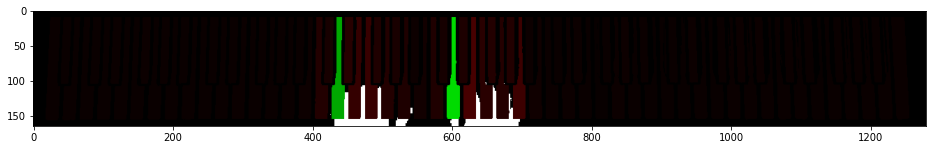

In [145]:
# highlight the keys that are pressed (above threshold)

centroids = [(i,np.mean(np.where(labels == i), axis=1)[0])
                for i in range(1,89)]
# only keep the index of the black keys which have a y-centroid between less than 100
black_keys = [c[0] for c in centroids if c[1] < 100]
white_keys = [c[0] for c in centroids if c[1] >= 100]

def highlight_keys(image_hand, image_diff, threshold):
    new_image = image_hand.copy()
    for i in range(1,89):
        list_testing = get_list_pixels(image_hand, i, above=10)
        color = average_color(image_diff, list_testing)
        mean_color = np.mean(color)
        if mean_color > threshold:
            new_image[np.where(labels == i)] = [0,mean_color,0]
        else:
            new_image[np.where(labels == i)] = [mean_color,0,0]
    return new_image

plt.figure(figsize=(16,6))
plt.imshow(highlight_keys(frame_hands_isolated, diff, 150))
plt.show()

In [147]:
# with sliders

def show_frame_from_video_and_key_pressed(frame_number):
    ret, frame = bfc.get_frame(cap, frame_number)
    if ret:
        frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
        image1 = get_hand_region(frame, 30, False)
        image1 = cv2.cvtColor(image1.astype(np.uint8), cv2.COLOR_BGR2RGB)
        image2 = get_difference_mask(cap, frame_number, show=False)
        plt.figure(figsize=(16,6))
        plt.imshow(frame)
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(image2)
        plt.show()
        plt.figure(figsize=(16,6))
        plt.imshow(highlight_keys(image1, image2, 130))
        plt.show()
    else:
        print('Frame not found')

import ipywidgets as widgets
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
interact(show_frame_from_video_and_key_pressed, frame_number=widgets.IntSlider(min=0, max=n, step=1, value=270))


interactive(children=(IntSlider(value=270, description='frame_number', max=916), Output()), _dom_classes=('wid…

<function __main__.show_frame_from_video_and_key_pressed(frame_number)>

# Pipeline final

In [44]:
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')
_, mask = bfc.get_frame(cap, 814)
mask = bfc.crop_frame(mask, 375, 0, 540-375, mask.shape[1], show=False)
n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pipe = pkn.pipeline(mask, with_hull=True, threshold = 4000, kx=15, crop=[10,7,15,19], min_area=300, max_width=200, show=False)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

Number of connected components: 88


  0%|          | 0/36 [00:00<?, ?it/s]

In [45]:
def get_hand_region(frame, threshold=30, show=False):
    new_frame = frame.std(axis=2)
    new_frame[:30,:] = 0
    new_frame[new_frame < threshold] = 0
    new_frame[new_frame >= threshold] = 255
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(new_frame, cmap='gray')
        plt.show()
    return new_frame

def get_list_pixels(image_hand, key_number, above = False): # above > 0 if we want the pixels to be far from fingers
    result = np.where((labels == key_number) & (image_hand[:,:,0] < 10))
    if not above:
        return result
    pixels_hided = np.where((labels == key_number) & (image_hand[:,:,0] > 200))
    # pixels around the hand shouldn't be considered because the color is influenced
    if len(pixels_hided[0]) > 0:
        highest_pixel = pixels_hided[0].min()
    else :
        highest_pixel = 120 # in fact, we shouldn't consider this because no finger above the key
    return (result[0][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))],
            result[1][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))])

def get_list_pixels_faster_computation(image_hand, key_number, above = False): # above > 0 if we want the pixels to be far from fingers
    x,y = centroids[key_number]
    # we want to check only the pixels around the centroid, say x-20 to x+20 to make the computation faster
    region_to_check_labels = labels[:, int(x-20):int(x+20)]
    region_to_check_hand = image_hand[:, int(x-20):int(x+20)]
    result = np.where((region_to_check_labels == key_number) & (region_to_check_hand[:,:,0] < 10))
    result = (result[0], result[1]+int(x-20))
    if not above:
        return result
    pixels_hided = np.where((region_to_check_labels == key_number) & (region_to_check_hand[:,:,0] > 200))
    pixels_hided = (pixels_hided[0], pixels_hided[1]+int(x-20))
    # pixels around the hand shouldn't be considered because the color is influenced
    if len(pixels_hided[0]) > 0:
        highest_pixel = pixels_hided[0].min()
    else :
        highest_pixel = 120
    return (result[0][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))],
            result[1][(result[0] > 10) & (result[0] <= min(110,max(0,highest_pixel-above)))])

def highlight_keys(image_hand, image_diff, threshold):
    new_image = image_hand.copy()
    for i in range(1,89):
        list_testing = get_list_pixels_faster_computation(image_hand, i, above=10)
        color = np.mean(image_diff[list_testing[0], list_testing[1]], axis=0)
        mean_color = np.mean(color)
        if mean_color > threshold:
            new_image[np.where(labels == i)] = [0,mean_color,0]
        elif mean_color > 50:
            new_image[np.where(labels == i)] = [mean_color,0,0]
    return new_image

def pipeline_key_pressed(img, mask, threshold_hand=30, above=10, threshold_confidence=150, show=False):
    image1 = get_hand_region(img, threshold_hand)
    image1 = cv2.cvtColor(image1.astype(np.uint8), cv2.COLOR_BGR2RGB)
    image2 = img - mask + 10
    image = highlight_keys(image1, image2, threshold_confidence)
    image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(image)
        plt.show()
    return image

In [65]:
def show_frame_from_video_and_key_pressed(frame_number, threshold_hand=30, above=10, threshold_confidence=150):
    _, frame = bfc.get_frame(cap, frame_number)
    frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
    if frame is not None:
        plt.figure(figsize=(20,6))
        plt.imshow(pipeline_key_pressed(frame, mask, threshold_hand, above, threshold_confidence, show=False))
        plt.show()
    else:
        print('Frame not found')

interact(show_frame_from_video_and_key_pressed, frame_number=(0, n-1, 1),
            threshold_hand=(0, 255, 1), above=(0, 100, 1), threshold_confidence=(0, 255, 1))

interactive(children=(IntSlider(value=457, description='frame_number', max=915), IntSlider(value=30, descripti…

<function __main__.show_frame_from_video_and_key_pressed(frame_number, threshold_hand=30, above=10, threshold_confidence=150)>

In [43]:
#fourcc = cv2.VideoWriter_fourcc(*'h264')
#out = cv2.VideoWriter('mp4/keyboard_confidence.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS),
#            (frame.shape[1],540-375))

from tqdm import tqdm
cap = cv2.VideoCapture('mp4/scarborough_fair.mp4')

for i in tqdm(range(0, n)):
    ret, frame = cap.read()
    if ret:
        frame = bfc.crop_frame(frame, 375, 0, 540-375, frame.shape[1], show=False)
        frame = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB)
        image = pipeline_key_pressed(frame, mask, threshold=30, above=10, threshold_diff=130, show=False)
        image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
#        out.write(image)
    else:
        break

#out.release()




  7%|▋         | 67/916 [00:02<00:27, 31.42it/s]


KeyboardInterrupt: 

In [51]:
# attach audio from mp4/scarborough_fair.mp4 to mp4/keyboard_confidence.mp4

#!ffmpeg -i mp4/keyboard_confidence.mp4 -i mp4/scarborough_fair.mp4 -c copy -map 0:v:0 -map 1:a:0 mp4/keyboard_confidence_with_audio.mp4